In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("transaction_dataset.csv")

In [7]:
df.shape

(9841, 51)

In [9]:
df.dtypes

Unnamed: 0                                                int64
Index                                                     int64
Address                                                  object
FLAG                                                      int64
Avg min between sent tnx                                float64
Avg min between received tnx                            float64
Time Diff between first and last (Mins)                 float64
Sent tnx                                                  int64
Received Tnx                                              int64
Number of Created Contracts                               int64
Unique Received From Addresses                            int64
Unique Sent To Addresses                                  int64
min value received                                      float64
max value received                                      float64
avg val received                                        float64
min val sent                            

In [13]:
df.columns = df.columns.str.strip().str.replace(r'\b\s+b','_', regex=True)
df.columns

Index(['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min_etween sent tnx',
       'Avg min_etween received tnx', 'Time Diff_etween first and last (Mins)',
       'Sent tnx', 'Received Tnx', 'Number of Created Contracts',
       'Unique Received From Addresses', 'Unique Sent To Addresses',
       'min value received', 'max value received', 'avg val received',
       'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether_alance', 'Total ERC20 tnxs',
       'ERC20 total Ether received', 'ERC20 total ether sent',
       'ERC20 total Ether sent contract', 'ERC20 uniq sent addr',
       'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1',
       'ERC20 uniq rec contract addr', 'ERC20 avg time_etween sent tnx',
       'ERC20 avg time_etween 

In [15]:
df.duplicated(subset = 'Index').sum()

5112

In [19]:
df['FLAG'].value_counts(normalize=True)

FLAG
0    0.778579
1    0.221421
Name: proportion, dtype: float64

In [21]:
df[df.duplicated(subset = 'Index')]['FLAG'].value_counts(normalize = True)

FLAG
0    0.573748
1    0.426252
Name: proportion, dtype: float64

In [23]:
df.duplicated().sum()

0

In [25]:
df = df.drop(columns = ['Unnamed: 0','Index', 'Address'])

In [27]:
categories = df.select_dtypes(include = 'object').columns

In [29]:
for i in df[categories].columns:
    print(f'The categorical column{i} has {df[i].nunique()} unique values and {df[i].isnull().sum()} missing values')

The categorical columnERC20 most sent token type has 304 unique values and 2697 missing values
The categorical columnERC20_most_rec_token_type has 466 unique values and 871 missing values


In [31]:
numerics = df.select_dtypes(include = 'number').columns

In [35]:
df[numerics].var()[df[numerics].var() == 0].index
constant_cols = df[numerics].var()[df[numerics].var() == 0].index
constant_cols

Index(['ERC20 avg time_etween sent tnx', 'ERC20 avg time_etween rec tnx',
       'ERC20 avg time_etween rec 2 tnx', 'ERC20 avg time_etween contract tnx',
       'ERC20 min val sent contract', 'ERC20 max val sent contract',
       'ERC20 avg val sent contract'],
      dtype='object')

In [37]:
len(constant_cols)

7

In [39]:
df.drop(constant_cols, axis = 1, inplace = True)

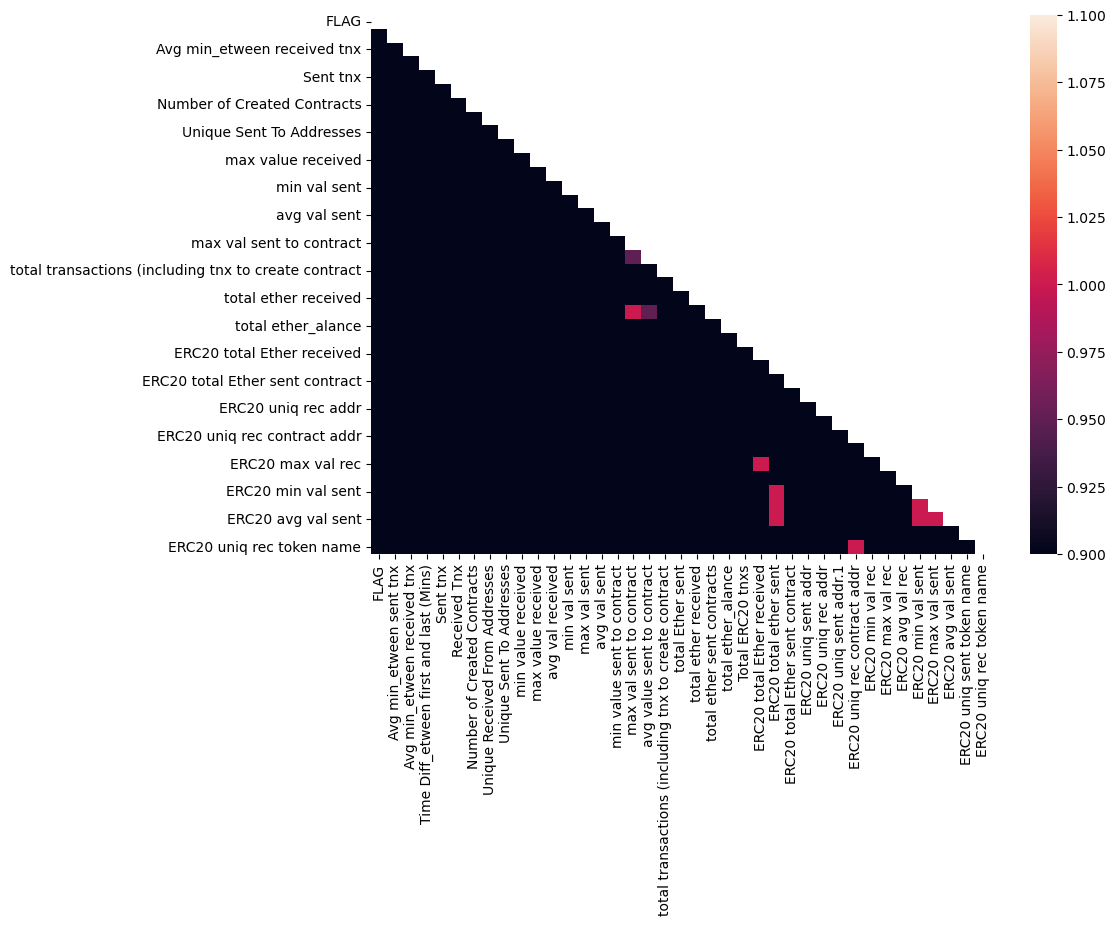

In [41]:
plt.figure(figsize = (10,7))
numerics = df.select_dtypes(include = 'number').columns
corr = df[numerics].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr, mask=mask, annot=False, vmin=1, vmax=1)
plt.show()

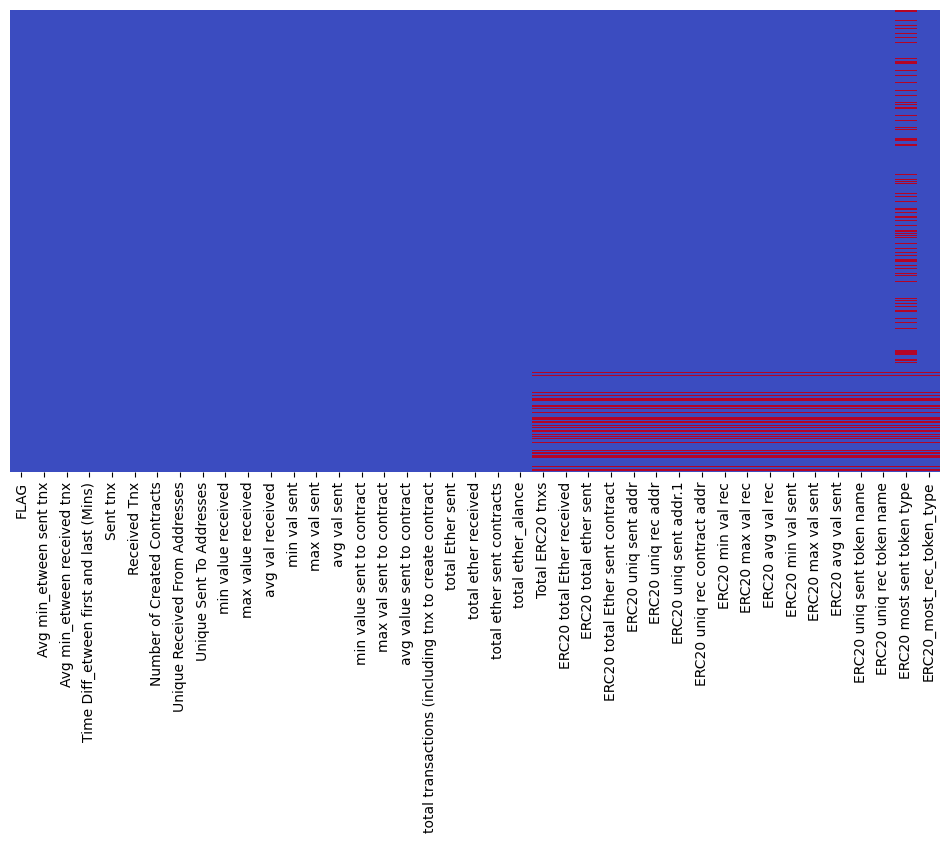

In [43]:
plt.figure(figsize = (12,6))
sns.heatmap(df.isnull(), cmap = 'coolwarm', cbar = False)
plt.yticks([])
plt.show()

In [45]:
missing_rows_count = df.isnull().any(axis=1).sum()
print(f"The number of rows with missing data is: {missing_rows_count}")

The number of rows with missing data is: 2720


In [51]:
missing_mask = df.isnull().any(axis=1)
print(df.loc[missing_mask, 'FLAG'].value_counts())
print(" ")
print(round(df.loc[missing_mask, 'FLAG'].value_counts(normalize = True), 2))

FLAG
0    1891
1     829
Name: count, dtype: int64
 
FLAG
0    0.7
1    0.3
Name: proportion, dtype: float64


In [53]:
print(df['FLAG'].value_counts())
print(" ")
print(round(df['FLAG'].value_counts(normalize = True), 2))



FLAG
0    7662
1    2179
Name: count, dtype: int64
 
FLAG
0    0.78
1    0.22
Name: proportion, dtype: float64


In [57]:
print(df[~missing_mask].shape)
df_sub= df[~missing_mask]

(7121, 41)


In [59]:
X = df_sub.drop('FLAG', axis = 1)
y = df_sub['FLAG']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)

In [61]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [65]:
from category_encoders import TargetEncoder
encoder = TargetEncoder(cols = categories)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [67]:
train = pd.concat([X_train_encoded, y_train], axis = 1)
test = pd.concat([X_test_encoded, y_test], axis = 1)


In [69]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(contamination = 'auto', random_state = 123)
isolation_forest.fit(train)
anomaly_train_pred = isolation_forest.predict(train)
anomaly_test_pred = isolation_forest.predict(test)
is_train = np.sum(anomaly_train_pred == -1)
is_test = np.sum(anomaly_test_pred == -1)
print("Number of outliers in the train set:", is_train)
print("Number of outliers in the test set:", is_test)

Number of outliers in the train set: 196
Number of outliers in the test set: 55


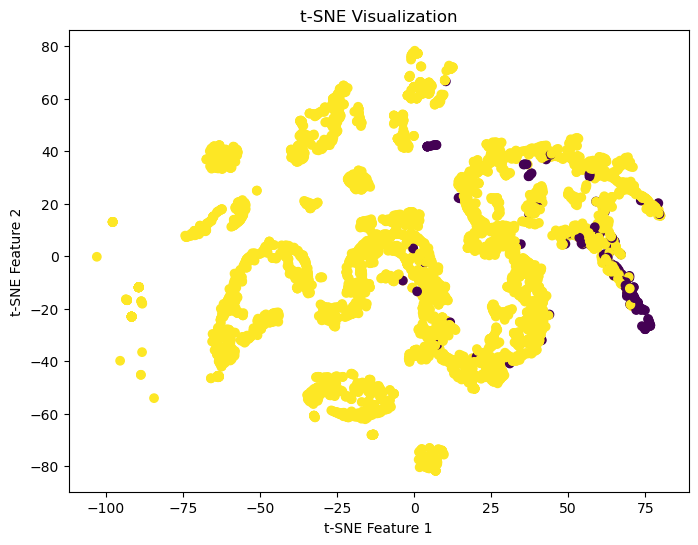

In [71]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 123)
X_train_tsne = tsne.fit_transform(X_train_encoded)

plt.figure(figsize = (8,6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=anomaly_train_pred)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


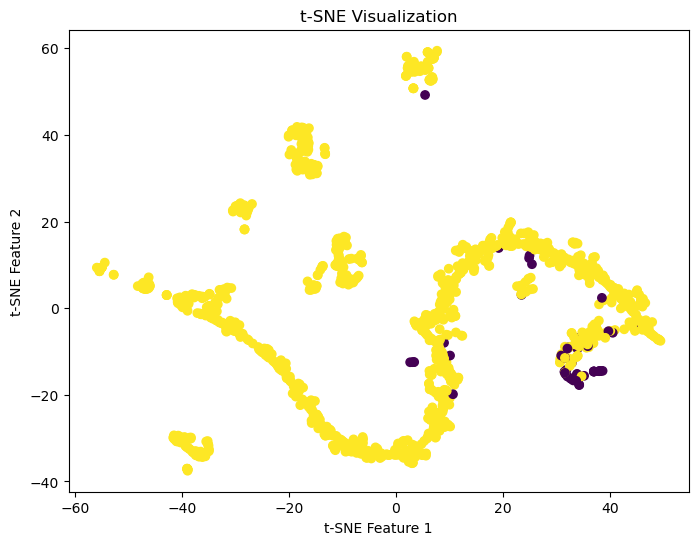

In [73]:
X_test_tsne = tsne.fit_transform(X_test_encoded)

plt.figure(figsize = (8,6))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=anomaly_test_pred)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()